# Assignment
- 아래 코드를 완성하여 다중레이블 분류문제를 푸는 신경망을 학습하고자 한다.

In [3]:
# 아래의 패키지 중 numpy, matplotlib는 기존에 설치되어 있어야 한다.
# spiral.py가 본 주피터 노트북 파일과 같은 디렉토리에 있어야 한다.
import numpy as np
import sys
import spiral
import matplotlib.pyplot as plt

In [4]:
# 이 블럭의 코드는 수정하지 않고 그대로 실행하여 사용한다.
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

Problem 1.
다음 레이어들에 대한 클래스를 정의하는 파이썬 코드를 완성하라.
- Affine
- Sigmoid

In [5]:
class Affine:
    """활성값 객체 구현"""

    def __init__(self, W, b):
        """
        가중치, 바이어스를 매개변수(parameter)로 저장한다.
        가중치, 바이어스는 학습 과정에서 갱신된다.
        """
        self.params = [W, b]    # 가중치 벡터 W, 바이어스 b
        self.grads = [np.zeros_like(W), np.zeros_like(b)]   # 역전파 계산 후 update되는 W와 b의 gradient list
        self.x = None   # feature vector

    def forward(self, x):
        """순전파"""
        W, b = self.params          # 현재 가중치 벡터 W, 바이어스 b
        self.x = x                  # feature vector update
        return self.x @ W + b       # 순전파 계산


    def backward(self, dout):
        """역전파"""
        W, b = self.params          # 현재 가중치 벡터 W, 바이어스 b
        dx = dout @ W.T             # dL/dx = dL/dy @ W.T
        dW = self.x.T @ dout        # dL/dW = X.T @ dL/dy
        db = np.sum(dout, axis=0)   # bias gradient 를 각 노드들의 dy 합으로 계산

        self.grads[0][:] = dW       # 현재 가중치 벡터의 gradient 저장
        self.grads[1][:] = db       # 현재 bias gradient 저장
        return dx                   # dx 연산값

In [6]:
class Sigmoid:
    """시그모이드 객체 구현"""

    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        """순전파"""
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, dout):
        """역전파"""
        return self.out * (1. - self.out) * dout

## Problem 2.
Stochastic gradient descent 알고리즘을 클래스로 구현하라.

In [7]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for i, grad in enumerate(grads):
            params[i] -= self.lr * grad

## Problem 3.
아래 그림과 같은 구조를 갖는 신경망 `TwoLayerNet`을 클래스로 구현하는 코드를 완성하라.

(`Affine`-`Sigmoid`-`Affine`-`SoftmaxWithLoss`)

![](https://fmcl.synology.me/image/deep_learning_2_images/fig%201-13)


In [8]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 가중치와 편향 초기화
        np.random.seed(999)
        W1 = np.random.randn(I, H)
        b1 = np.random.randn(H)
        W2 = np.random.randn(H, O)
        b2 = np.random.randn(O)

        # 계층 생성
        self.layers = [Affine(W1, b1), Sigmoid(), Affine(W2, b2)]
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

## Problem 4.
다음 블럭의 코드는 주어진 spiral 데이터셋을 사용하여 3개의 레이블에 대한 다중레이블 분류를 수행하는 신경망을 훈련시키는 코드다.
- 앞에서 문제 1~3에서 개발한 클래스들이 아래 코드를 실행하여 문제없이 잘 동작하는지 확인하라.

### Problem 4.1.
- `batch_size`를 1, 5, 30으로 변경시켜서 각각 훈련하였을 때, 시각화 결과와 손실함수 변화 그래프를 비교하고 설명하라.

### Problem 4.2.
- `learning_rate`를 0.1, 1, 20으로 변경시켜서 각각 훈련하였을 때, 시각화 결과와 손실함수 변화 그래프를 비교하고 설명하라.

### Problem 4.3.
- `hidden_size`를 10, 100으로 변경시켜서 각각 훈련하였을 때, 시각화에 걸리는 시간과 손실함수 변화 그래프를 비교하고 설명하라.

| 에폭 1 | 반복 10 / 10 | 손실 4.46
| 에폭 2 | 반복 10 / 10 | 손실 2.91
| 에폭 3 | 반복 10 / 10 | 손실 2.74
| 에폭 4 | 반복 10 / 10 | 손실 2.19
| 에폭 5 | 반복 10 / 10 | 손실 1.82
| 에폭 6 | 반복 10 / 10 | 손실 2.19
| 에폭 7 | 반복 10 / 10 | 손실 1.60
| 에폭 8 | 반복 10 / 10 | 손실 1.57
| 에폭 9 | 반복 10 / 10 | 손실 1.41
| 에폭 10 | 반복 10 / 10 | 손실 1.10
| 에폭 11 | 반복 10 / 10 | 손실 1.26
| 에폭 12 | 반복 10 / 10 | 손실 1.22
| 에폭 13 | 반복 10 / 10 | 손실 1.23
| 에폭 14 | 반복 10 / 10 | 손실 1.05
| 에폭 15 | 반복 10 / 10 | 손실 1.06
| 에폭 16 | 반복 10 / 10 | 손실 1.17
| 에폭 17 | 반복 10 / 10 | 손실 0.94
| 에폭 18 | 반복 10 / 10 | 손실 1.01
| 에폭 19 | 반복 10 / 10 | 손실 1.02
| 에폭 20 | 반복 10 / 10 | 손실 1.04
| 에폭 21 | 반복 10 / 10 | 손실 0.96
| 에폭 22 | 반복 10 / 10 | 손실 0.79
| 에폭 23 | 반복 10 / 10 | 손실 0.69
| 에폭 24 | 반복 10 / 10 | 손실 0.97
| 에폭 25 | 반복 10 / 10 | 손실 0.80
| 에폭 26 | 반복 10 / 10 | 손실 0.84
| 에폭 27 | 반복 10 / 10 | 손실 0.65
| 에폭 28 | 반복 10 / 10 | 손실 0.68
| 에폭 29 | 반복 10 / 10 | 손실 0.62
| 에폭 30 | 반복 10 / 10 | 손실 0.59
| 에폭 31 | 반복 10 / 10 | 손실 0.67
| 에폭 32 | 반복 10 / 10 | 손실 0.83
| 에폭 33 | 반복 10 /

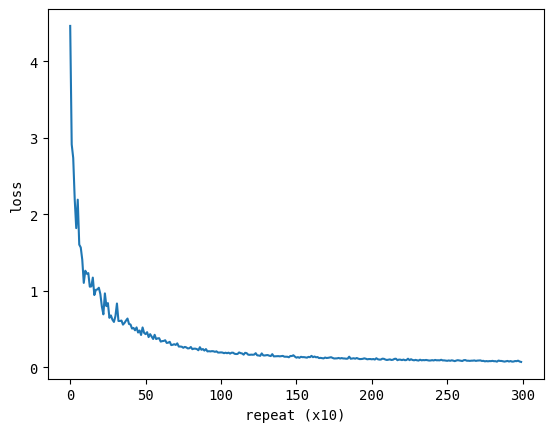

In [11]:
# 하이퍼파라미터 설정
max_epoch = 300
batch_size = 30
hidden_size = 100
learning_rate = 1

# 데이터 읽기, 모델 및 옵티마이저 생성
x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

# 학습에 사용하는 변수
data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
    # 데이터 섞기
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        batch_x = x[iters * batch_size : (iters + 1) * batch_size]
        batch_t = t[iters * batch_size : (iters + 1) * batch_size]

        # 기울기 계산 -> 매개변수 계산
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

        # 정기적으로 훈련결과 출력
        if (iters + 1) % 10 == 0:
            avg_loss = total_loss / loss_count
            print(
                "| 에폭 %d | 반복 %d / %d | 손실 %.2f"
                % (epoch + 1, iters + 1, max_iters, avg_loss)
            )
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0
# 학습 결과 플롯

plt.rc("font", family="monospace")
plt.plot(np.arange(len(loss_list)), loss_list, label="train")
plt.xlabel("repeat (x10)")
plt.ylabel("loss")
plt.show()

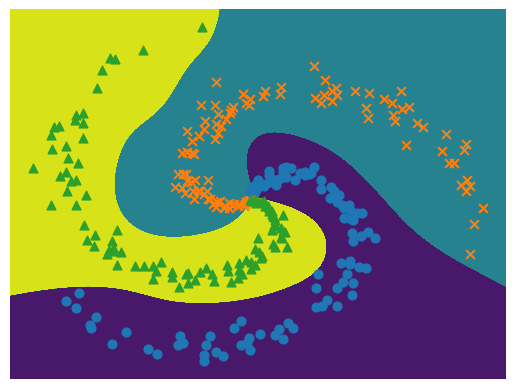

visualization time =  18.11350107192993


In [12]:
# 결과 시각화 스크립트
import time
# 경계 영역 플롯
start_time = time.time()
h = 0.001
x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis("off")

# 데이터점 플롯
x, t = spiral.load_data()
N = 100
CLS_NUM = 3
markers = ["o", "x", "^"]
for i in range(CLS_NUM):
    plt.scatter(
        x[i * N : (i + 1) * N, 0], x[i * N : (i + 1) * N, 1], s=40, marker=markers[i]
    )
plt.show()
end_time = time.time()

print("visualization time = ", end_time - start_time)

### Answer 4.1.



- `batch_size` == 1


![image.png](attachment:image.png) ![image.png](attachment:image-2.png)




- `batch_size` == 5


![image.png](attachment:image-3.png) ![image.png](attachment:image-4.png)




- `batch_size` == 30


![image.png](attachment:image-5.png) ![image.png](attachment:image-6.png)



### 해당 시각화 자료는 batch_size를 각각 1, 5, 30으로 설정 후 다중분류 문제를 학습하여 test한 결과와 학습 반복마다의 손실함수값 변화이다. batch_size마다 크게 손실값, 즉 모델 파라미터의 업데이트(그레디언트 업데이트)의 불안정성과 학습의 일반화 성능, 학습 시간을 비교해 볼 수 있다. (max_epoch = 300, hidden_size = 10, learning_rate = 1)

1) batch_size == 1
    - batch_size를 1로 설정하여서 학습하였을 때 손실함수 변화 그래프를 확인해보면 상당히 모델 파라미터의 최적값을 찾는데 불안정한 모습을 볼 수 있다. 모든 훈련 데이터셋을 하나씩 확인하여 특정한 하나의 데이터에 맞춰서 모델 파라미터를 업데이트 하게 된다. 따라서 하나의 batch마다 모델 파라미터 값이 크게 변동할 수 밖에 없으며 이로 인해 모델 파라미터의 업데이트 양상도 불안정해지게 된다. 또한 모든 train 데이터셋에서 하나의 데이터씩 학습을 하기 때문에 max epoch 300 기준 총 학습 시 반복을 8000번 이상하게 되며 학습을 진행하는 데 시간도 오래 소요되게 된다.  

    - 이러한 결과로 batch_size가 1로 설정되어 학습을 하게 되면 모델 파라미터 업데이트의 불안정성으로 batch 간의 미세한 변동에 민감하게 반응하게 된다. 민감한 반응으로 인해 특정 위치에서 최소값을 잘 탐색하여 모델이 global minimum이 아닌 local minimum에 수렴하여 더 나은 최소값을 찾지 못하는 문제를 해결할 수 있지만, train 데이터셋에 대한 과도한 모델 파라미터 피팅으로 인해 오버피팅을 유발하여 일반화 성능이 떨어질 수 있다. 최소값에 잘 도달하였다는 결과는 손실함수의 값이 결국 0에 도달하였다는 것을 확인하여 검증할 수 있다.  

    - 실제로 학습 모델의 시각화 결과를 확인해보면 오버피팅을 확인해볼 수 있다. 데이터셋에 대해 분류를 진행하였을 때 부드러운 곡선으로 분류를 하지 못하고 굴곡이 심하고 분류 영역이 불규칙적으로 표현되어 있는 것을 볼 수 있다. 이는 batch_size가 작아 훈련 데이터가 적기 때문에 train 데이터셋에만 너무 적합하게 모델 파라미터값이 튜닝되어 데이터셋에 대해 일반적인 분류를 못하게 된 것으로 볼 수 있으며, 일반화 성능이 떨어져 다른 데이터셋에 대한 정확한 분류를 수행하지 못할 수 있다.  

2) batch size == 5
    - batch size를 5로 설정하여서 학습하였을 때 손실함수 변화 그래프를 확인해보면 batch_size 1보다는 개선되었지만 여전히 모델 파라미터의 최적값을 찾는데 불안정한 모습을 볼 수 있다. 모든 훈련 데이터셋을 5개씩 확인하여 특정한 5개의 데이터에 맞춰서 모델 파라미터를 업데이트 하게 된다. 따라서 batch_size 1보다는 많은 데이터를 한 번에 확인하지만 모든 훈련 데이터셋의 개수에 비해 작은 개수의 batch이므로 모델 파라미터 값이 각 batch 마다 크게 변동할 수 밖에 없으며 이로 인해 모델 파라미터의 업데이트 양상도 불안정해지게 된다. 또한 모든 train 데이터셋에서 하나의 데이터씩 학습을 하기 때문에 max epoch 300 기준 총 학습 시 반복을 1750번 이상하게 되며 학습을 진행하는 데 시간도 오래 소요되게 된다.  

    - 이러한 결과로 batch_size가 5로 설정되어 학습을 하게 되면 모델 파라미터 업데이트의 불안정성으로 여전히 batch 간의 미세한 변동에 민감하게 반응하게 된다. 민감한 반응으로 인해 모델이 gloabal minimum이 아닌 local minimum에 수렴하여 더 나은 최소값을 찾지 못하는 문제를 해결할 수 있지만, train 데이터셋에 대한 과도한 모델 파라미터 피팅으로 인해 오버피팅을 유발하여 일반화 성능이 떨어질 수 있다. 최소값에 잘 도달하였다는 결과는 손실함수의 값이 결국 0에 도달하였다는 것을 확인하여 검증할 수 있다.  

    - 실제로 학습 모델의 시각화 결과를 확인해보면 약간의 오버피팅을 확인해볼 수 있다. 데이터셋에 대해 분류를 진행하였을 때 부드러운 곡선으로 분류를 하지 못하고 굴곡이 여전히 심하게 표현되어 있는 것을 확인해볼 수 있으며, batch_size 1보다는 규칙적으로 분류가 되어 있는 것을 확인해볼 수 있다. 이는 train 데이터셋에만 너무 적합하게 모델 파라미터값이 튜닝되어 다른 데이터셋에 대해 일반적인 분류를 못하게 된 것으로 볼 수 있으며, 일반화 성능이 떨어져 다른 데이터셋에 대한 정확한 분류를 수행하지 못할 수 있다.  

    - 결과적으로, batch_size 1일 때와 batch_size 5일 때를 비교해 본다면 batch_size 1보다는 모델 파라미터의 업데이트 안정성과 학습 속도가 약간 개선되었다고 볼 수 있으며, 오버피팅 문제도 batch_size 1보다는 개선이 되었음을 비교해 볼 수 있다. 이를 통해 batch_size가 학습 시간과 수렴 안정성, 오버피팅에 영향을 끼치는 것을 확인해볼 수 있다.  

3) batch size == 30
    - batch_size를 30으로 설정하여서 학습하였을 때 손실함수 변화 그래프를 확인해보면 batch_size 5보다 훨씬 개선되어 비교적 안정적인 모습을 볼 수 있다. 모든 훈련 데이터셋을 30개씩 확인하여 특정한 30개의 데이터에 맞춰서 모델 파라미터를 업데이트 하게 된다. 따라서 batch_size 5보다 많은 데이터를 한 번에 확인하여 모든 훈련 데이터셋의 개수에 대해 적절한 비율의 batch 개수이므로 모델 파라미터 값이 각 batch 마다 안정적으로 변동하게 되어 모델 파라미터의 업데이트 양상도 비교적 안정적으로 이루어지게 된다. 또한 모든 train 데이터셋에서 30개의 데이터씩 학습을 하기 때문에 max epoch 300 기준 총 학습 시 반복을 300번 하게 되며 학습을 진행하는 데 걸리는 시간도 batch size 5에 비해 월등히 개선되었음을 확인해 볼 수 있다.  

    - 이러한 결과로 batch_size가 30으로 설정되어 학습을 하게 되면 모델 파라미터 업데이트가 안정적으로 이루어지게 되어 모델 파라미터의 최적값을 찾는 속도가 다소 오래 소요될 수 있으며, 다소 미세한 변동에 둔감하게 반응하여 모델이 gloabal minimum이 아닌 local minimum에 수렴하여 더 나은 최소값을 찾지 못하는 문제가 발생할 수 있다. 수렴 속도가 느리므로 최소값에 잘 도달하지 못한 결과는 손실함수의 값이 결국 0에 도달하지 못한 것을 확인하여 검증할 수 있다. 하지만 모델 파라미터 업데이트의 안정성으로 인해 train 데이터셋에 대한 과도한 모델 파라미터 피팅이 아닌 일반적인 피팅으로 인해 오버피팅을 회피하여 일반화 성능이 향상될 수 있다.  

    - 실제로 학습 모델의 시각화 결과를 확인해보면 오버피팅이 없는 것을 확인해볼 수 있다. 데이터셋에 대해 분류를 진행하였을 때 부드러운 곡선으로 분류를 진행하였고, 굴곡이 완만하게 표현되어 있는 것을 확인해볼 수 있으며, batch_size 1보다는 훨씬 규칙적으로 분류가 되어 있는 것을 확인해볼 수 있다. 이는 train 데이터셋에만 너무 적합하지 않고 일반적으로 모델 파라미터값이 튜닝되어 데이터셋에 대해 일반적인 분류를 잘 수행하게 되는 것을 기대할 수 있으며, 일반화 성능이 향상되어 정확한 global minimum을 찾지 못할 수 있어 여전히 손실값이 남아 있을 수 있지만 오히려 batch_size 1,5보다 test 데이터셋에 대한 정확한 분류 수행할 수 있다.  

    - 결과적으로, batch_size 1,5일 때와 batch_size 30일 때를 비교해 본다면 batch_size 1,5보다는 모델 파라미터의 업데이트 안정성과 학습 속도가 월등히 개선되었다고 볼 수 있으며, 오버피팅 문제도 batch_size 1,5보다는 훨씬 개선이 되었음을 비교해 볼 수 있다. 이를 통해 batch_size가 학습 시간과 수렴 안정성, 오버피팅에 영향을 끼치는 것을 뚜렷하게 확인해볼 수 있다.

-> 요약하자면, batch_size는 모델 파라미터의 수렴 안정성, 오버피팅, local minimum 탈출과 일반화 성능 등 학습 성능에 큰 영향을 미친다. 수렴 안정성과 일반화 성능을 높이고 오버피팅 문제, 학습 시간 문제를 해결하기 위해 batch_size는 너무 작으면 안되고 반대로 local minimum 탈출을 위해 batch size가 적절히 커야 한다. 따라서 batch 정규화 기법을 활용하여 평균이 0이 되고 분산이 1이 되도록 학습의 품질을 높이거나 적절한 batch_size의 하이퍼파라미터 값을 찾아 최적화를 하여 학습 성능을 높여야 한다. 이외에 교차검증을 통해 적절한 하이퍼파라미터를 찾는 방법도 존재한다.
  
    - 다음 과정은 하이퍼파라미터 최적화 과정이다.  
        (1) 하이퍼파라미터 값 범위를 설정한다.  
        (2) 범위 내에서 무작위로 추출한다.  
        (3) 추출한 하이퍼파라미터로 학습하고, 검증 데이터로 정확도를 평가한다.  
        (4) 2,3단계를 여러번 실시, 가장 좋은 결과를 내는 결과를 바탕으로 하이퍼파라미터 값 범위를 재설정한다.(1단계)  
        => 점점 범위를 좁혀가며 최종적으로 특정 하이퍼파라미터를 결정하고 Test dataset으로 성능을 평가한다.

### Answer 4.2.



- `learning_rate` == 0.1


![image.png](attachment:image-4.png) ![image.png](attachment:image-2.png)



- `learning_rate` == 1


![image.png](attachment:image.png) ![image.png](attachment:image-3.png)



- `learning_rate` == 20


![image.png](attachment:image-7.png) ![image.png](attachment:image-5.png)


### 해당 시각화 자료는 learning_rate를 각각 1, 5, 30으로 설정 후 다중분류 문제를 학습하여 test한 결과와 epoch마다의 손실함수값 변화이다. learning_rate마다 크게 손실값의 수렴속도, 즉 모델 파라미터의 업데이트(그레디언트 업데이트)의 속도와 수렴 성능, 오버/언더슈팅, 학습의 일반화 성능을 비교해 볼 수 있다. (max_epoch = 300, batch_size = 30, hidden_size = 10)

   1) learning_rate == 0.1  
      - learning_rate를 0.1로 설정하여 학습하였을 때 손실함수 변화 그래프를 확인해보면 최적의 파라미터에 수렴이 눈에 띄게 도달하지 못한 결과를 확인해볼 수 있다. 그레디언트 계산값을 반영하는 비율이 너무 작기 때문에 아주 조금씩 움직이며 수렴하려고 하기 때문에 정해진 epochs안에 최적의 파라미터를 찾지 못한 결과이다. 하지만 수렴 시간이 오래 걸리지만 손실함수 값의 감소는 조금씩 이동하며 안정적으로 이루어지게 된다. 그래프에서 300번을 반복하여 학습한 결과 최종 손실함수 값을 0.6까지 밖에 줄이지 못하였지만 안정적으로 줄이는 양상을 보인다. 또한 그레디언트가 굉장히 작게 이동함으로 인해 local minimum에서 갇혀버리는 문제가 발생할 수 있다. 아주 조금씩 이동하여 global minimum에 도달하지 못하고 해당 위치를 탈출하지 못해 최적값에 도달하지 못할 수 있다. 이 결과를 통해 learning_rate가 너무 작으면 수렴 속도가 느리게 되고 local minimum에서 갇혀 최적점에 도달하지 못할 수 있는 문제가 있지만 학습의 안정성(수렴 성능)은 뛰어나다는 것을 볼 수 있다.  

      - 또한 실제로 학습 모델의 시각화 결과를 확인해보면 언더피팅을 확인해볼 수 있다. learning_rate가 너무 작기 때문에 데이터에 제대로 적응하지 못하여 분류를 제대로 하지 못하게 된다. 이는 정해진 epoch안에 최적의 손실함수값을 찾지 못하여 발생하게 된다. 그레디언트 계산값을 아주 조금 반영하여 파라미터의 업데이트로 인한 최적점에 수렴 속도가 느리기 때문에 학습이 다 완료 되지 못하며 분류가 부정확하게 이루어지게 된다. 분류 결과 시각화 자료를 확인해보면 올바른 학습이 이루어지기 전 단계임을 확인해볼 수 있다. 구역이 단순하게 나뉘어져 주어진 데이터에 대해 분류하지 못하는 데이터의 양이 많아 모델의 정확도가 상당히 낮은 것을 확인할 수 있다. 이는 다른 데이터에도 마찬가지일 것이며, 일반화 성능이 아주 떨어진다는 것이라고 할 수 있다.

   2) learning_rate == 20  
      - learning_rate를 20으로 설정하여 학습하였을 때 손실함수 변화 그래프를 확인해보면 최적의 파라미터에 수렴이 약간 도달하였지만 굉장히 불안정한 양상임을 확인할 수 있다. 최적값에 도달하는 속도는 learning_rate 0.1보다 빨랐다. 하지만 그레디언트 계산값을 반영하는 비율이 너무 커서 크게 크게 움직이며 수렴하려고 하기 때문에 정해진 epochs내에서 그래프가 마치 진동하는 듯한 양상을 보인다. 하지만 그레디언트가 굉장히 크게 이동함으로 인해 local minimum에서 탈출하여 global minimum에 도달할 수 있는 확률이 높아진다. 이 결과를 통해 learning_rate가 커질 수록 수렴 속도는 빠르고 local minimum을 탈출할 수 있지만 학습의 안정성(수렴 성능)은 감소한다는 것을 볼 수 있다.  

      - 이로 인해 실제로 학습 모델의 시각화 결과를 확인해보면 오버피팅을 확인해볼 수 있다. learning_rate가 너무 크기 때문에 데이터에 너무 과하게 적응하여 오버피팅이 일어나게 되어 분류의 일반화 성능이 매우 떨어지게 된다. 이는 정해진 epoch안에서 그레디언트 업데이트가 큰 값으로 이루어져 모델이 최적점에서 벗어나게 되어 발생되는 현상이다. 그레디언트 계산값을 아주 크게 반영하여 파라미터의 업데이트로 인해 훈련이 빠르게 진행될 수 있지만  최적점 수렴 성능이 굉장히 불안정하기 때문에 최악의 경우 발산하거나 튀는 현상이 발생할 가능성이 높다. 이로 인해 모델은 train 데이터에 대한 오버피팅이 이루어지게 되며 분류가 과도하게 train 데이터에만 적합하게 된다. 또한 그레디언트의 과도한 이동으로 학습의 성능이 저하되어 정확한 분류를 수행하지 못할 수도 있다. 분류 결과 시각화 자료를 확인해보면 분류를 위한 구역이 나뉘어진 모양의 굴곡이 심하며 불규칙적으로 분류의 성능이 저하된 것을 볼 수 있다. 이를 통해 적절한 learning_rate를 설정하여 모델의 언더피팅과 오버피팅을 방지해야 함을 알 수 있다.  

   3) learning_rate == 1  
      - learning_rate를 1로 설정하여 학습하였을 때 learning_rate 0.1일 때의 수렴 속도 문제와 learning_rate 20일 떄의 수렴 안정성 문제를 모두 개선한 양상을 보인다. 손실함수 변화 그래프를 확인해보면 최적의 파라미터에 수렴이 약간 도달하지는 못하였지만, learning_rate 0.1일 때보다 최적점을 향하는 수렴 속도가 빠른 모습을 보이며 learning_rate 20일 때보다 훨씬 안정적으로 최적점을 향하는 것을 확인할 수 있다. 그레디언트 계산값을 반영하는 비율이 너무 작지는 않지만 조금씩 움직이며 수렴하려고 하기 때문에 정해진 epochs안에 최적의 파라미터를 찾지 못한 결과이다. 또한 learning_rate 0.1일 때의 손실함수값 그래프보다 약간 불안정한 모습을 보이지만 학습에 큰 영향을 끼칠 정도가 아니며 learning_rate 20일 때보다 수렴 속도가 느리지만 이 또한 학습에 큰 영향을 끼칠 정도가 아니다. 그래프에서 300번을 반복하여 학습한 결과 최종 손실함수 값을 0.2 이하까지 줄이게 되고 발산과 진동의 위험성을 크게 보이지 않으며 learning_rate 0.1, 20보다 더 개선된 좋은 성능을 보였다. 이 결과를 통해 수렴 속도가 어느 정도 빠르고 안정성 있는 튜닝을 위해 적절한 learning_rate를 설정이 중요하다는 것을 알 수 있다.  

      - 또한 실제로 학습 모델의 시각화 결과를 확인해보면 일반화 성능이 어느 정도 형성된 분류 결과를 볼 수 있다. learning_rate가 비교적 적절하여 데이터에 충분히 적응하였고 분류를 제대로 수행하는 모습을 보인다.  그레디언트 계산값을 적절하게 반영하여 파라미터의 업데이트가 수행되기 때문에 데이터에 대한 분류를 적절히 수행되는 모습을 보이며 언더슈팅과 오버슈팅의 문제가 모두 개선된 모습을 확인할 수 있다. 분류 결과 시각화 자료를 확인해보면 데이터에 대한 올바른 분류를 진행하며 구역이 잘 나뉘어져 다른 데이터들의 분류도 문제없이 수행할 수 있음을 기대해 볼 수 있다.  

   -> 요약하자면, learning_rate는 모델 파라미터의 수렴 속도/성능, 오버/언더피팅, local minimum 탈출과 일반화 성능 등 학습 성능에 큰 영향을 미친다. 수렴 속도의 저하, 언더피팅 문제, local minimum 탈출을 해결하기 위해 learning_rate는 너무 작으면 안되지만 반대로 수렴 성능의 저하, 오버슈팅 문제를 해결하기 위해 learning_rate가 또한 너무 커서는 안된다. 과도하거나 과소한 learning_rate는 또한 일반화 성능에 큰 영향을 미치기 때문에 적절한 learning_rate의 값을 찾기 위한 최적화 과정이 필요하며 learning_rate를 동적으로 조절하는 여러 기법들을 활용하거나 많은 하이퍼파라미터 튜닝 기법을 활용하여 최적의 learning_rate를 찾아야 한다.
  
    - 다음 과정은 하이퍼파라미터 최적화 과정이다.  
        (1) 하이퍼파라미터 값 범위를 설정한다.  
        (2) 범위 내에서 무작위로 추출한다.  
        (3) 추출한 하이퍼파라미터로 학습하고, 검증 데이터로 정확도를 평가한다.  
        (4) 2,3단계를 여러번 실시, 가장 좋은 결과를 내는 결과를 바탕으로 하이퍼파라미터 값 범위를 재설정한다.(1단계)  
        => 점점 범위를 좁혀가며 최종적으로 특정 하이퍼파라미터를 결정하고 Test dataset으로 성능을 평가한다.

### Answer 4.3.



- `hidden_size` = 10


![image.png](attachment:image-2.png) ![image.png](attachment:image.png)



- `hidden_size` = 100


![image.png](attachment:image-3.png) ![image.png](attachment:image-4.png)